In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import graph_tool.all as gt
import nltk
import itertools

from collections import defaultdict
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer

In [34]:
# Data importing
data_folder = "../data/Data_citation/" 


author_paper_biadj = np.loadtxt(f"{data_folder}authorPaperBiadj.txt", delimiter="\t", dtype=int)
author_list = np.loadtxt(f"{data_folder}authorList.txt", delimiter="\t", dtype=str)
paper_cit_adj = pd.read_csv(f"{data_folder}paperCitAdj.txt", delimiter=" ", header=None)
paper_list = pd.read_csv(f"{data_folder}paperList.txt", sep=",", header=0)

1. `paper_list` stores the text information.
2. `author_list` stores the name of the authors
3. `author_paper_biadj` stores the author - paper relationship.
4. `paper_cit_adj` stores the citation network


In [35]:
# Data cleaning

## Creating a new column to store the word count of each abstract
paper_list['word_count'] = paper_list['abstract'].astype(str).apply(lambda x: len(x.split()))

## Finding the paper index with insufficient word
remove_index = paper_list[paper_list['word_count'] < 20].index.tolist()

## Removing
filtered_papers = paper_list.drop(index=remove_index)
filtered_cit_adj = paper_cit_adj.drop(index=remove_index, columns=remove_index)

author_paper_df = pd.DataFrame(author_paper_biadj, columns=paper_list.index)
filtered_author_paper = author_paper_df.drop(columns=remove_index)

# Graph building

1. Node are the abstracts
2. Edges are the citation(directed)

In [36]:
# Graph building
G2 = nx.from_pandas_adjacency(filtered_cit_adj, create_using=nx.Graph)

# Save the graph as an edge list
edge_list = list(G2.edges())
edge_df = pd.DataFrame(edge_list, columns=["Source", "Target"])

print("Number of Nodes (Documents):", G2.number_of_nodes())
print("Number of Edges (Citations):", G2.number_of_edges())

Number of Nodes (Documents): 3206
Number of Edges (Citations): 5669


In [37]:
coauthor_edges = set()
num_authors = filtered_author_paper.shape[0]

for author in range(num_authors):
    # Use .iloc to get the row for the current author.
    row = filtered_author_paper.iloc[author]
    # Get the list of paper indices (i.e. the column labels) where the value is nonzero.
    papers = [col for col, val in row.items() if val != 0]
    # For every unordered pair of papers, add one undirected edge.
    for p, q in itertools.combinations(papers, 2):
        edge = tuple(sorted((p, q)))
        coauthor_edges.add(edge)

added_edges = 0
for edge in coauthor_edges:
    if not G2.has_edge(*edge):
        G2.add_edge(*edge)
        added_edges += 1

print("Added", added_edges, "coauthorship edges.")
print("New total number of edges:", G2.number_of_edges())

Added 15687 coauthorship edges.
New total number of edges: 21356


# SBM

In [38]:
# -------------------------------
# Build a graph-tool graph from the NetworkX graph, storing original paper IDs.
# -------------------------------
G_gt = gt.Graph(directed=False)
# Create a mapping from paper ID (from G2.nodes()) to a graph-tool vertex.
node_map = {paper_id: G_gt.add_vertex() for paper_id in G2.nodes()}

# Add edges to the graph-tool graph
for src, tgt in G2.edges():
    G_gt.add_edge(node_map[src], node_map[tgt])

# Create a vertex property to store the original paper ID.
paper_id_prop = G_gt.new_vertex_property("int")
for paper_id, vertex in node_map.items():
    paper_id_prop[vertex] = int(paper_id)

In [39]:
# -------------------------------
# Run SBM
# -------------------------------
state = gt.minimize_blockmodel_dl(G_gt, state_args={"B": 5})
blocks2 = state.get_blocks()

In [40]:
# -------------------------------
# Compute community sizes and filter out small communities.
# -------------------------------
community_labels = blocks2.a  # NumPy array of community labels
unique, counts = np.unique(community_labels, return_counts=True)
community_sizes = dict(zip(unique, counts))
print("Community sizes:", community_sizes)

# Set the minimum community size threshold.
min_size = 30

def vfilt(v):
    # Keep only vertices belonging to communities with size at least min_size.
    return community_sizes[blocks2[v]] >= min_size

G_filtered = gt.GraphView(G_gt, vfilt=vfilt)
print("Number of nodes after filtering:", G_filtered.num_vertices())
print("Number of edges after filtering:", G_filtered.num_edges())

# -------------------------------
# Extract the original paper IDs from the filtered graph.
# -------------------------------
filtered_paper_ids = {int(paper_id_prop[v]) for v in G_filtered.vertices()}
print("Number of filtered paper IDs:", len(filtered_paper_ids))

# -------------------------------
# Filter the papers DataFrame to include only those documents in large communities.
# -------------------------------
filtered_paper_list = filtered_papers.loc[filtered_papers.index.isin(filtered_paper_ids)]
print("Filtered paper_list shape:", filtered_paper_list.shape)

Community sizes: {64: 17, 89: 25, 100: 16, 166: 42, 203: 65, 301: 27, 381: 69, 434: 88, 744: 13, 753: 58, 802: 36, 871: 41, 929: 28, 942: 401, 1022: 63, 1082: 58, 1173: 71, 1219: 20, 1236: 20, 1302: 58, 1312: 17, 1337: 105, 1358: 67, 1393: 99, 1401: 44, 1438: 10, 1456: 24, 1521: 70, 1539: 26, 1542: 8, 1563: 30, 1567: 24, 1580: 36, 1703: 7, 1765: 69, 1791: 28, 1831: 79, 1836: 20, 1968: 22, 1990: 112, 1992: 58, 2011: 24, 2032: 23, 2100: 73, 2120: 27, 2130: 55, 2151: 38, 2152: 32, 2296: 31, 2374: 33, 2436: 45, 2490: 24, 2507: 36, 2642: 77, 2644: 53, 2661: 28, 2664: 65, 2699: 40, 2791: 43, 2806: 35, 2885: 59, 2899: 34, 2966: 29, 2980: 24, 3025: 51, 3055: 51, 3190: 5}
Number of nodes after filtering: 2670
Number of edges after filtering: 12020
Number of filtered paper IDs: 2670
Filtered paper_list shape: (2670, 6)


## Understanding the communities

Number of communities in filtered graph: 41
Minimum community size: 30
Maximum community size: 401
Median community size: 58.0
Average community size: 65.1219512195122


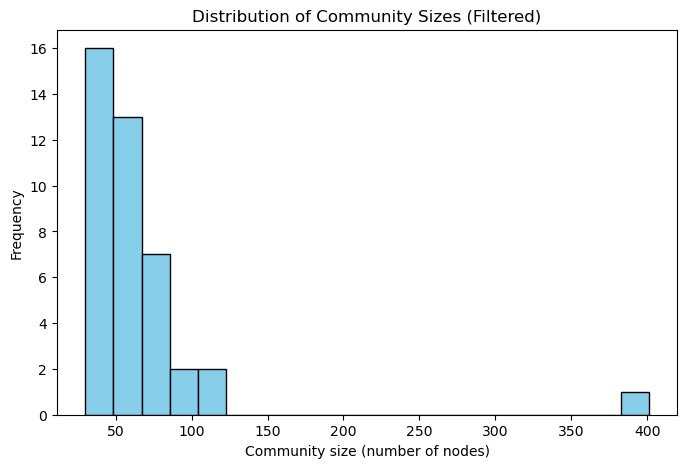

In [52]:
# Get the community label for each vertex in the filtered graph.
# (blocks2 is the vertex property from SBM)
filtered_labels = np.array([blocks2[v] for v in G_filtered.vertices()])

# Compute unique community labels and their sizes.
unique_labels, counts = np.unique(filtered_labels, return_counts=True)

num_communities = len(unique_labels)
min_comm_size = counts.min()
max_comm_size = counts.max()
median_comm_size = np.median(counts)
avg_comm_size = counts.mean()

print("Number of communities in filtered graph:", num_communities)
print("Minimum community size:", min_comm_size)
print("Maximum community size:", max_comm_size)
print("Median community size:", median_comm_size)
print("Average community size:", avg_comm_size)

# Optionally, show a histogram of community sizes.
plt.figure(figsize=(8, 5))
plt.hist(counts, bins=20, color="skyblue", edgecolor="k")
plt.xlabel("Community size (number of nodes)")
plt.ylabel("Frequency")
plt.title("Distribution of Community Sizes (Filtered)")
plt.show()

In [53]:
filtered_labels = np.array([blocks2[v] for v in G_filtered.vertices()])
unique_labels, counts = np.unique(filtered_labels, return_counts=True)

# 2. Sort communities by size (descending)
sorted_communities = sorted(zip(unique_labels, counts), key=lambda x: x[1], reverse=True)

print("Communities (label, size) in descending order:")
for label, size in sorted_communities:
    print(f"  Community {label}: size={size}")

Communities (label, size) in descending order:
  Community 942: size=401
  Community 1990: size=112
  Community 1337: size=105
  Community 1393: size=99
  Community 434: size=88
  Community 1831: size=79
  Community 2642: size=77
  Community 2100: size=73
  Community 1173: size=71
  Community 1521: size=70
  Community 381: size=69
  Community 1765: size=69
  Community 1358: size=67
  Community 203: size=65
  Community 2664: size=65
  Community 1022: size=63
  Community 2885: size=59
  Community 753: size=58
  Community 1082: size=58
  Community 1302: size=58
  Community 1992: size=58
  Community 2130: size=55
  Community 2644: size=53
  Community 3025: size=51
  Community 3055: size=51
  Community 2436: size=45
  Community 1401: size=44
  Community 2791: size=43
  Community 166: size=42
  Community 871: size=41
  Community 2699: size=40
  Community 2151: size=38
  Community 802: size=36
  Community 1580: size=36
  Community 2507: size=36
  Community 2806: size=35
  Community 2899: size

In [57]:
top_k = 1

for i, (comm_label, comm_size) in enumerate(sorted_communities[:top_k], start=1):
    print("========================================")
    print(f"Exploring Community {comm_label} (Rank {i}, size={comm_size})")
    
    # 3a. Build a subgraph for this community from G_filtered
    def community_filter(v):
        return blocks2[v] == comm_label
    G_comm = gt.GraphView(G_filtered, vfilt=community_filter)
    print("  Subgraph nodes:", G_comm.num_vertices(), "intraconmmunity edges:", G_comm.num_edges())

    # 3b. Extract the original paper IDs from this subgraph
    comm_paper_ids = [int(paper_id_prop[v]) for v in G_comm.vertices()]

    # 3c. Subset your DataFrame to these papers
    df_comm = filtered_paper_list.loc[filtered_paper_list.index.isin(comm_paper_ids)]
    print("  Number of papers in DataFrame:", df_comm.shape[0])

    # 3d. Inspect some summary stats
    print("  Word count stats: min =", df_comm['word_count'].min(),
          ", max =", df_comm['word_count'].max(),
          ", mean =", df_comm['word_count'].mean())

    # 3e. Maybe show a few titles or abstracts
    print("\n=========== Sample Abstracts==========")
    print(df_comm['title'].head(5).to_string(index=False))

Exploring Community 942 (Rank 1, size=401)
  Subgraph nodes: 401 intraconmmunity edges: 375
  Number of papers in DataFrame: 401
  Word count stats: min = 22 , max = 378 , mean = 152.39650872817955

=========== Sample Abstracts==========
Robust recovery of multiple subspaces by geomet...
Erich {L}eo {L}ehmann---a glimpse into his life...
Bayesian analysis of variable-order, reversible...
On optimality of the {S}hiryaev-{R}oberts proce...
           Kernel density estimation via diffusion


# Corpus processing

1. remove abstract with less than 20 words and delet correcponding entry in the citation network
2. convert the abstract into BOW(corpus)

Preprocessing steps:

1. tokenize and convert to lowercase
2. lemmatization
3. stop word removal
4. bad-of-word

In [60]:
# Process the abstracts
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))
vectorizer = CountVectorizer()

def preprocess_text(text):
    """Tokenizes, lemmatizes, and removes stopwords."""
    words = word_tokenize(text.lower())  # Tokenize and convert to lowercase
    words = [lemmatizer.lemmatize(word) for word in words if word.isalpha() and word not in stop_words]
    return " ".join(words)

# Apply preprocessing to abstracts
filtered_paper_list["processed_abstract"] = filtered_paper_list["abstract"].astype(str).apply(preprocess_text)

# Create Corpus (Bag-of-Words Model)
bow_matrix = vectorizer.fit_transform(filtered_paper_list["processed_abstract"])
corpus = pd.DataFrame(bow_matrix.toarray(), index=filtered_paper_list.index, columns=vectorizer.get_feature_names_out())

/var/folders/0r/kk1hzrmn3gn15tq_k14nb0r00000gn/T/ipykernel_91904/510167351.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_paper_list["processed_abstract"] = filtered_paper_list["abstract"].astype(str).apply(preprocess_text)


In [62]:
print(corpus.shape)

(2670, 9743)


## LDA

In [64]:
from sklearn.decomposition import LatentDirichletAllocation

num_topics = 6
lda_model = LatentDirichletAllocation(n_components=num_topics, random_state = 42)

doc_topic_dist = lda_model.fit_transform(corpus)

# Create a DataFrame for the document-topic distributions
doc_topic_df = pd.DataFrame(
    doc_topic_dist,
    index=filtered_paper_list.index,  # ensure index matches the filtered papers
    columns=[f"Topic_{i}" for i in range(num_topics)]
)

# Build a mapping from paper (node) to its community from the SBM results
# (node_map is the dict mapping from paper index in G2 to graph-tool vertices)
paper_community = {paper_id: blocks2[vertex] for paper_id, vertex in node_map.items()}

# Map each document in filtered_paper_list to its community (if not found, assign NaN)
doc_topic_df['Community'] = filtered_paper_list.index.map(lambda idx: paper_community.get(idx, np.nan))

# Now, compute the average topic distribution for each community
community_topic_dist = doc_topic_df.groupby("Community").mean()

print("Average Topic Distribution per Community:")
print(community_topic_dist)

Average Topic Distribution per Community:
            Topic_0   Topic_1   Topic_2   Topic_3   Topic_4   Topic_5
Community                                                            
166        0.198484  0.082608  0.385836  0.094107  0.176409  0.062556
203        0.096261  0.059146  0.129564  0.027949  0.492318  0.194762
381        0.187960  0.246596  0.262299  0.138886  0.071357  0.092901
434        0.168354  0.054493  0.255214  0.205390  0.193837  0.122711
753        0.042072  0.058955  0.074676  0.018695  0.037469  0.768132
802        0.048050  0.052608  0.611331  0.007478  0.042224  0.238309
871        0.306093  0.016892  0.367331  0.098353  0.109559  0.101772
942        0.213283  0.104468  0.272949  0.115515  0.160417  0.133369
1022       0.094098  0.225420  0.116827  0.116186  0.392417  0.055053
1082       0.128911  0.016758  0.401736  0.097846  0.238287  0.116464
1173       0.246152  0.106935  0.229595  0.254938  0.094075  0.068305
1302       0.166987  0.067981  0.561300  0.04064

<Figure size 1200x800 with 0 Axes>

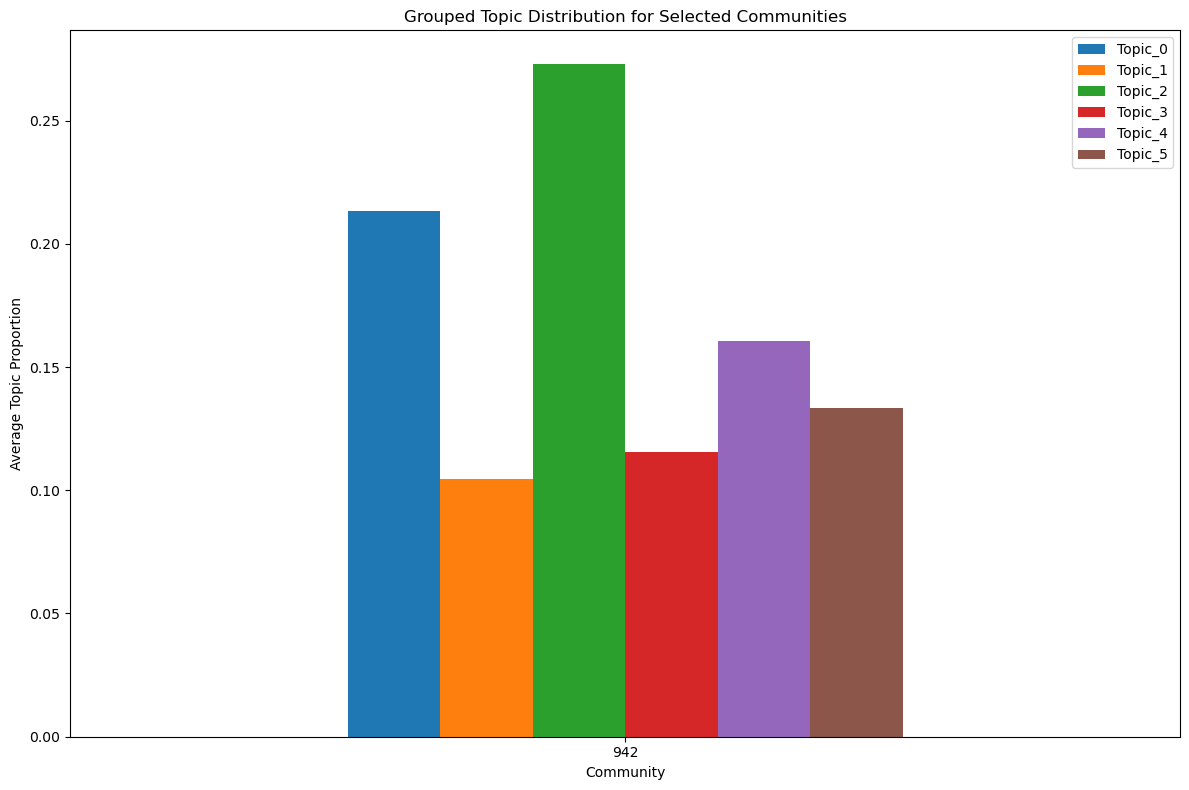

In [65]:
selected_communities = [942]  
selected_data = community_topic_dist.loc[selected_communities]

# Grouped Bar Plot
plt.figure(figsize=(12, 8))
grouped_ax = selected_data.plot(kind='bar', figsize=(12, 8))
grouped_ax.set_title("Grouped Topic Distribution for Selected Communities")
grouped_ax.set_xlabel("Community")
grouped_ax.set_ylabel("Average Topic Proportion")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [66]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        # Get the indices of the top words for this topic
        top_features_ind = topic.argsort()[:-no_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        print(f"Topic {topic_idx}:")
        print("  ", " ".join(top_features))
        
no_top_words = 30
feature_names = vectorizer.get_feature_names_out()
print("\nTop words for each topic:")
display_topics(lda_model, feature_names, no_top_words)


Top words for each topic:
Topic 0:
   model data method approach matrix analysis process variable covariance functional using function component spatial based estimate time selection used also problem parameter study result linear regression structure sample statistical random
Topic 1:
   model prior parameter distribution effect random study inference data bayesian process result outcome posterior mixture two exposure set likelihood analysis assumption class probability causal may one treatment dirichlet method variable
Topic 2:
   estimator function model distribution regression method parameter estimation likelihood density asymptotic result proposed data error problem estimate also rate show study procedure based simulation sample mean nonparametric variance class condition
Topic 3:
   model distribution time estimator data regression method study process proposed asymptotic function conditional hazard simulation event interval probability survival likelihood estimation approach i

### Inferring the Topics from LDA Model

| **Topic** | **Focus** | **Keywords** |
|-----------|----------|-------------|
| **Topic 0: Linear Algebra & Probabilistic Methods** | High-dimensional probability, PCA, covariance structures. | `matrix, covariance, principal, vector, random variable, space, dimension, graph, theta, prior, function, parameter, mean, example` |
| **Topic 1: Statistical Estimation & Regression Models** | Parametric/nonparametric estimation, likelihood, regression. | `estimator, regression, likelihood, estimation, asymptotic, error, variance, density, function, parameter, simulation, study, process` |
| **Topic 2: Optimization & Machine Learning Algorithms** | Feature selection, classification, optimization techniques. | `optimal, selection, algorithm, classification, lasso, criterion, probability, risk, rule, property, factor, paper, case` |
| **Topic 3: Bayesian Inference & Survival Analysis** | Bayesian inference, causal modeling, survival analysis. | `prior, likelihood, inference, hazard, survival, covariates, Bayesian, assumption, effect, outcome, treatment, regression, function` |
| **Topic 4: Bayesian Methods & Monte Carlo Simulation** | MCMC, Bayesian hierarchical models, stochastic processes. | `Markov, Monte Carlo, Bayesian, chain, spatial, inference, random, distribution, modeling, process, estimate, application, algorithm` |
| **Topic 5: Hypothesis Testing & Statistical Significance** | Hypothesis testing, FDR control, bioinformatics. | `test, hypothesis, statistic, null, false, multiple, power, discovery, gene, error, sampling, model, approach, expression` |

## hLDA

In [67]:
import tomotopy as tp
from collections import defaultdict

max_depth = 4 

# Create the hLDA model
model_hlda = tp.HLDAModel(depth=max_depth, alpha=1.0, gamma=0.1, eta=0.01, min_cf=5, rm_top=0)

# Create a list to map the order of documents in the hLDA model to your original paper IDs.
doc_mapping = list(filtered_paper_list.index)

# Add documents to the model.
for doc in filtered_paper_list["processed_abstract"]:
    tokens = doc.split()  # our preprocessing already lowercased and removed stopwords/punctuation
    model_hlda.add_doc(tokens)

for i in range(0, 1000, 100): 
    model_hlda.train(100)

In [69]:
def print_hlda_tree(model, topic_id=0, level=0, max_level=3):
    if level > max_level:
        return
    # Get the top words for the current topic
    top_words = " ".join([w for w, prob in model.get_topic_words(topic_id, top_n=5)])
    # Get the document count for the current topic
    doc_count = model.num_docs_of_topic(topic_id)
    print("  " * level + f"Level {level} - Topic {topic_id}: Count={doc_count}, Top words: {top_words}")
    # Recursively print each child topic
    for child in model.children_topics(topic_id):
        print_hlda_tree(model, topic_id=child, level=level+1, max_level=max_level)

# Example usage (assuming model_hlda is your trained HLDAModel and max_depth is defined):
print("\nhLDA Topic Tree:")
print_hlda_tree(model_hlda, topic_id=0, level=0, max_level=max_depth)


hLDA Topic Tree:
Level 0 - Topic 0: Count=2670, Top words: model method data approach study
  Level 1 - Topic 123: Count=1, Top words: gait shape human space subject
    Level 2 - Topic 144: Count=1, Top words: interpolation data method estimator distribution
      Level 3 - Topic 466: Count=1, Top words: planar recognition geodesic analyzing sequence
  Level 1 - Topic 121: Count=1, Top words: structure maximal number meet digital
    Level 2 - Topic 112: Count=1, Top words: word computable mathematical false distribution
      Level 3 - Topic 36: Count=1, Top words: principle meaningful image according whole
  Level 1 - Topic 14: Count=1, Top words: inefficiency cost bank technical allocative
    Level 2 - Topic 415: Count=1, Top words: model data method estimator distribution
      Level 3 - Topic 755: Count=1, Top words: least data method estimator distribution
  Level 1 - Topic 176: Count=4, Top words: incidence estimator cohort survey aging
    Level 2 - Topic 307: Count=3, Top w

In [71]:
# -------------------------------
# 2. Compute the combined community topic distribution.
# -------------------------------
# Build a mapping from each community (from SBM) to the list of document indices in our hLDA model.
community_docs = defaultdict(list)
for i, paper_id in enumerate(doc_mapping):
    comm = paper_community.get(paper_id, None)
    if comm is not None:
        community_docs[comm].append(i)  # store document index

# Combine topic counts for each community.
# The key for each node is (level, topic_id)
community_topic_total = {}
for comm, doc_indices in community_docs.items():
    topic_counts = defaultdict(float)
    for doc_idx in doc_indices:
        doc = model_hlda.docs[doc_idx]
        for lvl, topic_id in enumerate(doc.path):
            key = (lvl, int(topic_id))
            topic_counts[key] += 1
    community_topic_total[comm] = topic_counts

# We can simply remove nodes with zero count by filtering (although they won't appear in the dictionary)
community_topic_dist = {}
for comm, counts in community_topic_total.items():
    # Only include nodes with a positive count
    filtered_counts = {key: count for key, count in counts.items() if count > 0}
    total = sum(filtered_counts.values())
    normalized = { key: count / total for key, count in filtered_counts.items() } if total > 0 else {}
    community_topic_dist[comm] = normalized

# For example, print the normalized distribution for community 56:
community_id = 942
if community_id in community_topic_dist:
    print(f"\nCommunity {community_id} Topic Distribution (Combined & Normalized):")
    for (lvl, topic_id), prob in sorted(community_topic_dist[community_id].items()):
        print(f"  Level {lvl} - Topic {topic_id}: {prob:.3f}")
else:
    print(f"Community {community_id} not found in the distribution.")


Community 942 Topic Distribution (Combined & Normalized):
  Level 0 - Topic 0: 0.250
  Level 1 - Topic 8: 0.236
  Level 1 - Topic 10: 0.001
  Level 1 - Topic 12: 0.001
  Level 1 - Topic 13: 0.001
  Level 1 - Topic 14: 0.001
  Level 1 - Topic 80: 0.001
  Level 1 - Topic 81: 0.002
  Level 1 - Topic 86: 0.001
  Level 1 - Topic 87: 0.001
  Level 1 - Topic 120: 0.001
  Level 1 - Topic 121: 0.001
  Level 1 - Topic 122: 0.001
  Level 1 - Topic 124: 0.001
  Level 1 - Topic 176: 0.001
  Level 1 - Topic 178: 0.001
  Level 1 - Topic 179: 0.002
  Level 1 - Topic 280: 0.001
  Level 2 - Topic 16: 0.132
  Level 2 - Topic 17: 0.012
  Level 2 - Topic 19: 0.001
  Level 2 - Topic 40: 0.001
  Level 2 - Topic 41: 0.001
  Level 2 - Topic 43: 0.001
  Level 2 - Topic 44: 0.001
  Level 2 - Topic 45: 0.001
  Level 2 - Topic 46: 0.001
  Level 2 - Topic 64: 0.001
  Level 2 - Topic 66: 0.001
  Level 2 - Topic 68: 0.001
  Level 2 - Topic 69: 0.001
  Level 2 - Topic 70: 0.002
  Level 2 - Topic 92: 0.001
  Level 2 -

In [72]:
# -------------------------------
# 3. Reconstruct the pruned subtree for a particular community.
# -------------------------------
def reconstruct_subtree_pruned(model, norm_dist, current_level, topic_id, max_level, threshold=0.0):
    """
    Recursively reconstruct a subtree for a community.
    
    Nodes with normalized probability equal to the threshold (or below) are pruned.
    Here threshold=0.0 means we ignore nodes that are simply not present.
    """
    key = (current_level, topic_id)
    if key not in norm_dist or norm_dist[key] <= threshold:
        return None
    node_info = {
        "level": current_level,
        "topic_id": topic_id,
        "probability": norm_dist[key],
        "top_words": model.get_topic_words(topic_id, top_n=5),
        "children": []
    }
    if current_level < max_level:
        for child_topic in model.children_topics(topic_id):
            child_node = reconstruct_subtree_pruned(model, norm_dist, current_level + 1, child_topic, max_level, threshold)
            if child_node is not None:
                node_info["children"].append(child_node)
    return node_info

def print_subtree(node, indent=0):
    if node is None:
        return
    prefix = "  " * indent
    top_words = " ".join([w for w, prob in node["top_words"]])
    print(f"{prefix}Level {node['level']} - Topic {node['topic_id']} (Prob: {node['probability']:.3f}): {top_words}")
    for child in node["children"]:
        print_subtree(child, indent+1)

# Extract the subtree for community 56 (pruning nodes with zero probability).
if community_id in community_topic_dist:
    norm_dist_comm = community_topic_dist[community_id]
    subtree_comm = reconstruct_subtree_pruned(model_hlda, norm_dist_comm, current_level=0, topic_id=0, max_level=max_depth, threshold=0.0)
    print(f"\nPruned Sub-Topic Tree for Community {community_id}:")
    if subtree_comm is not None:
        print_subtree(subtree_comm)
    else:
        print("  No subtree found after pruning.")
else:
    print(f"Community {community_id} not found.")


Pruned Sub-Topic Tree for Community 942:
Level 0 - Topic 0 (Prob: 0.250): model method data approach study
  Level 1 - Topic 121 (Prob: 0.001): structure maximal number meet digital
    Level 2 - Topic 112 (Prob: 0.001): word computable mathematical false distribution
      Level 3 - Topic 36 (Prob: 0.001): principle meaningful image according whole
  Level 1 - Topic 14 (Prob: 0.001): inefficiency cost bank technical allocative
    Level 2 - Topic 415 (Prob: 0.001): model data method estimator distribution
      Level 3 - Topic 755 (Prob: 0.001): least data method estimator distribution
  Level 1 - Topic 176 (Prob: 0.001): incidence estimator cohort survey aging
    Level 2 - Topic 307 (Prob: 0.001): whereby data method estimator distribution
      Level 3 - Topic 49 (Prob: 0.001): specie individual community occurrence constructed
    Level 2 - Topic 92 (Prob: 0.001): sullivan consistent stationarity rapidly centered
      Level 3 - Topic 639 (Prob: 0.001): life assumption method exp

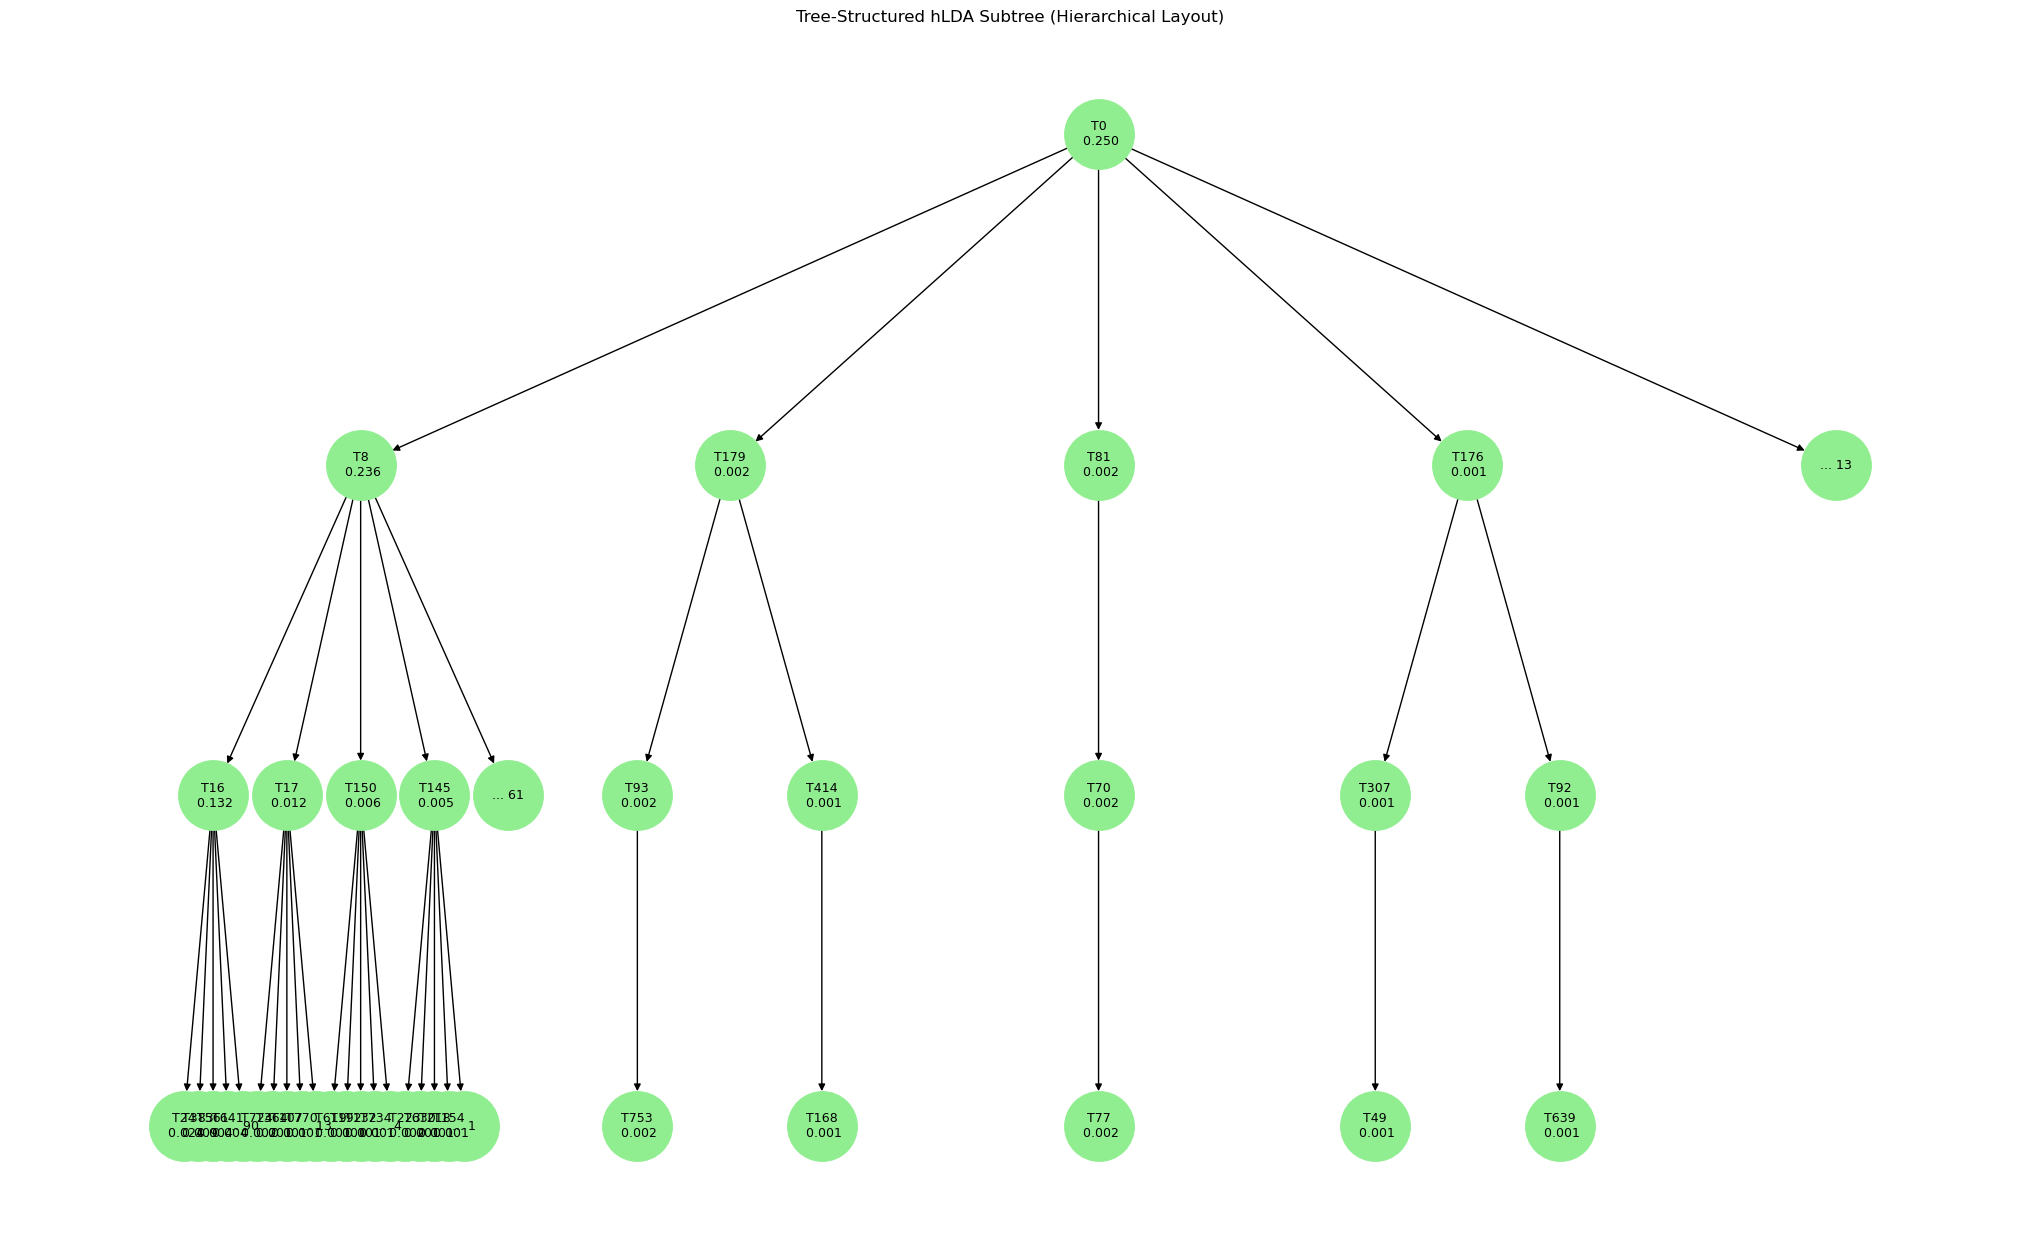

In [73]:
def hierarchy_pos(
    G,
    root=None,
    width=1.0,
    vert_gap=0.2,
    vert_loc=0,
    xcenter=0.5,
    pos=None,
    parent=None
):
    if pos is None:
        pos = {root: (xcenter, vert_loc)}
    else:
        pos[root] = (xcenter, vert_loc)
    children = list(G.successors(root))
    if len(children) != 0:
        dx = width / len(children)
        nextx = xcenter - width / 2 - dx / 2
        for child in children:
            nextx += dx
            pos = hierarchy_pos(
                G,
                root=child,
                width=dx,
                vert_gap=vert_gap,
                vert_loc=vert_loc - vert_gap,
                xcenter=nextx,
                pos=pos,
                parent=root
            )
    return pos
# Suppose `subtree_comm` is your pruned subtree for the chosen community.
# Example: subtree_comm = reconstruct_subtree_pruned(model_hlda, norm_dist_comm, ...)

# We limit each node to the top K children by probability
TOP_K_CHILDREN = 4

G = nx.DiGraph()
node_id_counter = [0]  # store the next node ID in a list so we can mutate it

def add_subtree_to_graph(node, parent_id=None, top_k=TOP_K_CHILDREN):
    """
    Recursively add `node` to the DiGraph, including up to `top_k` children.
    If there are more children, group them into a single placeholder node.
    """
    current_id = node_id_counter[0]
    node_id_counter[0] += 1
    
    # Create a label showing the node’s level, topic ID, and probability
    label = f"T{node['topic_id']}\n {node['probability']:.3f}"
    G.add_node(current_id, label=label)
    
    # Link from parent to current node
    if parent_id is not None:
        G.add_edge(parent_id, current_id)
    
    # Sort children by descending probability
    children = sorted(node["children"], key=lambda c: c["probability"], reverse=True)
    
    # If we have more children than top_k, group the rest
    if len(children) > top_k:
        # Add the top_k children
        for child in children[:top_k]:
            add_subtree_to_graph(child, parent_id=current_id, top_k=top_k)
        
        # Add a placeholder node summarizing how many were omitted
        leftover_count = len(children) - top_k
        placeholder_id = node_id_counter[0]
        node_id_counter[0] += 1
        G.add_node(placeholder_id, label=f"... {leftover_count}")
        G.add_edge(current_id, placeholder_id)
    else:
        # Otherwise, add them all
        for child in children:
            add_subtree_to_graph(child, parent_id=current_id, top_k=top_k)

# -- Build the graph from your subtree --
if subtree_comm is None:
    print("No subtree found for the chosen community.")
else:
    add_subtree_to_graph(subtree_comm, parent_id=None)

    # We'll assume that the node with ID=0 is the root node in this new graph.
    root_id = 0  # The very first node we added

    # Compute a hierarchical layout
    pos = hierarchy_pos(G, root=root_id, width=4.0, vert_gap=0.8)
    
    # Retrieve node labels
    node_labels = nx.get_node_attributes(G, 'label')
    
    # Plot
    plt.figure(figsize=(20, 12))
    nx.draw(
        G, pos,
        labels=node_labels,
        with_labels=True,
        node_color='lightgreen',
        node_size=2500,
        font_size=9,
        arrows=True
    )
    plt.title("Tree-Structured hLDA Subtree (Hierarchical Layout)")
    plt.show()

In [76]:
def extract_top_words_with_level(node, model, result=None):
    """
    Recursively traverse the subtree and for each node, extract:
      - level (stored in node["level"])
      - topic_id (stored in node["topic_id"])
      - node probability (stored in node["probability"])
      - top 20 words (retrieved from model.get_topic_words(topic_id, top_n=20))
      
    Returns a list of dictionaries.
    """
    if result is None:
        result = []
    
    # Retrieve top 20 words for this node from the model
    top_words = model.get_topic_words(node["topic_id"], top_n=20)
    result.append({
        "level": node["level"],
        "topic_id": node["topic_id"],
        "node_probability": node["probability"],
        "top_words": top_words
    })
    
    for child in node.get("children", []):
        extract_top_words_with_level(child, model, result)
        
    return result

# Example usage for a particular community (e.g. community 56):
if subtree_comm is None:
    print("No subtree available for extraction.")
else:
    top_words_info = extract_top_words_with_level(subtree_comm, model_hlda)
    
    print("Top 20 words for each node in the subtree:")
    for info in top_words_info:
        print(f"Level {info['level']} - Topic {info['topic_id']} (Node Prob: {info['node_probability']:.3f}):")
        # Print each word with its probability (rounded)
        for word, prob in info["top_words"]:
            print(f"    {word}: {prob:.4f}")
        print()

Top 20 words for each node in the subtree:
Level 0 - Topic 0 (Node Prob: 0.250):
    model: 0.0411
    method: 0.0293
    data: 0.0283
    approach: 0.0146
    study: 0.0126
    using: 0.0119
    analysis: 0.0109
    used: 0.0097
    proposed: 0.0089
    based: 0.0087
    propose: 0.0084
    simulation: 0.0076
    use: 0.0072
    estimate: 0.0071
    new: 0.0070
    variable: 0.0066
    two: 0.0065
    article: 0.0065
    also: 0.0064
    parameter: 0.0062

Level 1 - Topic 121 (Node Prob: 0.001):
    structure: 0.0721
    maximal: 0.0433
    number: 0.0289
    meet: 0.0289
    digital: 0.0289
    geometric: 0.0289
    priori: 0.0289
    definition: 0.0289
    requirement: 0.0145
    contained: 0.0145
    alarm: 0.0145
    contains: 0.0145
    kind: 0.0145
    display: 0.0145
    minimal: 0.0145
    recently: 0.0145
    introduced: 0.0145
    state: 0.0145
    compatible: 0.0145
    occurrence: 0.0145

Level 2 - Topic 112 (Node Prob: 0.001):
    word: 0.0244
    computable: 0.0244
    m

## First way

In [ ]:
# Get number of authors and papers
num_authors, num_papers = author_paper_biadj.shape

# Step 1: Generate co-authorship edges
coauthor_edges = set()
for paper_idx in range(num_papers):
    authors = np.where(author_paper_biadj[:, paper_idx] == 1)[0]
    for author1, author2 in itertools.combinations(authors, 2):  # Co-author pairs
        coauthor_edges.add((author1, author2))

# Step 2: Generate citation-based edges
citation_edges = set()
for citing_paper in range(num_papers):
    cited_papers = np.where(paper_cit_adj[citing_paper] == 1)[0]  # Papers cited by this paper
    
    citing_authors = np.where(author_paper_biadj[:, citing_paper] == 1)[0]  # Authors of citing paper
    
    for cited_paper in cited_papers:
        cited_authors = np.where(author_paper_biadj[:, cited_paper] == 1)[0]  # Authors of cited paper
        
        for author1 in citing_authors:
            for author2 in cited_authors:
                if author1 != author2:  # Avoid self-loops
                    citation_edges.add((author1, author2))

# Combine co-authorship and citation edges
all_edges = coauthor_edges.union(citation_edges)

# Convert to a DataFrame for easy handling
edge_list_df = pd.DataFrame(list(all_edges), columns=["Author1", "Author2"])

In [ ]:
# Constructing NetworkX graph for visualisation
G = nx.Graph()
G.add_edges_from(edge_list_df.values)

# Convert NetworkX graph to Graph-Tool graph
gt_G = gt.Graph(directed=False)
author_map = {}  # Maps author ID to vertex

# Add nodes
for author in G.nodes:
    v = gt_G.add_vertex()
    author_map[author] = v  # Store mapping

# Add edges
for author1, author2 in G.edges:
    gt_G.add_edge(author_map[author1], author_map[author2])

In [ ]:
# Basic graph statistics
print("Number of vertices:", gt_G.num_vertices())
print("Number of edges:", gt_G.num_edges())

# Calculate density: density = (2 * E) / (V * (V-1))
print("Graph density:", 2 * gt_G.num_edges() / (gt_G.num_vertices() * (gt_G.num_vertices() - 1)))

# Component analysis
comp, hist = gt.label_components(gt_G)
print("\nNumber of connected components:", len(hist))
print("Size of largest component:", max(hist))

# Degree statistics
deg = gt_G.get_total_degrees(gt_G.get_vertices())
print("\nAverage degree:", sum(deg) / len(deg))
print("Maximum degree:", max(deg))
print("Minimum degree:", min(deg))

Number of vertices: 3539
Number of edges: 23541
Graph density: 0.003760248197785126

Number of connected components: 149
Size of largest component: 3132

Average degree: 13.303758123763775
Maximum degree: 303
Minimum degree: 1


### Fitting community detection algorithm

In [ ]:
# Infer the optimal stochastic block model
state = gt.minimize_blockmodel_dl(gt_G)  # Automatically detects communities

# Get the block assignments
blocks = state.get_blocks()

num_communities = len(set(blocks.a))
print(f"Number of communities detected: {num_communities}")

Number of communities detected: 86


In [ ]:
# Count nodes in each community
community_counts = defaultdict(int)
for v in gt_G.vertices():
    community_counts[blocks[v]] += 1

# Convert to DataFrame for easy visualization
community_df = pd.DataFrame(list(community_counts.items()), columns=["Community", "Num_Nodes"])

# Display the DataFrame
print(community_df)

    Community  Num_Nodes
0         837         88
1           2          4
2        1442         71
3        1658         12
4        1175         49
..        ...        ...
81       1392         35
82       1366         49
83       1150         46
84       2176         64
85       1505        113

[86 rows x 2 columns]
